In [1]:
import os
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb  # pip install lmdb
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights, mobilenet_v2, MobileNet_V2_Weights
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.utils.checkpoint import checkpoint  # For gradient checkpointing

logging.basicConfig(level=logging.INFO)

In [2]:
# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
GRADIENT_ACCUM_STEPS = 4      # Accumulate gradients over 4 mini-batches (simulate effective batch size = mini_batch * 4)
NUM_FRAMES = 30               # Use 30 frames per video

# ------------------------------
# Environment & Paths
# ------------------------------
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"  # Expect subfolders: Train, Validation, Test
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Data Transforms
# ------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Models directory exists: True
Checkpoint path writable: True
Using device: cuda


In [3]:
# ------------------------------
# Helper Functions
# ------------------------------
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    return base.replace("110001", "202614", 1) if base.startswith("110001") else base

def select_impactful_frames(video_folder: Path, num_frames=30):
    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    total_frames = len(frame_files)
    if total_frames == 0:
        return []
    if total_frames <= num_frames:
        return frame_files
    # For speed, select evenly spaced frames.
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    return [frame_files[i] for i in indices]

def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=30):
    """
    Precompute and cache the frame file paths for each video.
    Saves a pickle file with keys "valid_indices" and "precomputed_frames".
    """
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = csv_file.stem.replace("Labels", "").strip()
    valid_indices = []
    precomputed = []
    skipped = 0
    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Precomputing frames"):
        clip_id = get_csv_clip_id(row["ClipID"].split('.')[0])
        video_folder = video_root / split / clip_id
        if video_folder.exists():
            frames = select_impactful_frames(video_folder, num_frames)
            if len(frames) >= num_frames:
                precomputed.append(frames[:num_frames])
                valid_indices.append(idx)
            else:
                skipped += 1
        else:
            skipped += 1
    print(f"Precomputation: Skipped {skipped} videos out of {len(data)}.")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    cache_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}.pkl"
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Precomputed results saved to {cache_file}")
    return cache_data

def convert_pkl_to_lmdb(csv_file: Path, num_frames=30, transform=train_transform, lmdb_map_size=1 * 1024**3):
    """
    Convert the precomputed .pkl file into an LMDB database containing
    preprocessed feature tensors (in half precision) extracted by EfficientNet-B3.
    If the LMDB folder already exists, it is reused.
    """
    pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}.pkl"
    lmdb_path = CACHE_DIR / f"lmdb_{csv_file.stem}_frame_{num_frames}"
    # If the LMDB folder exists, assume it is valid and return its path.
    if lmdb_path.exists():
        print(f"LMDB database already exists at {lmdb_path}")
        return lmdb_path

    env = lmdb.open(str(lmdb_path), map_size=lmdb_map_size)
    try:
        with env.begin(write=False) as txn:
            if txn.stat()['entries'] > 0:
                print(f"LMDB database already exists at {lmdb_path}")
                env.close()
                return lmdb_path
    except lmdb.Error as e:
        print("Error checking LMDB database:", e)
    
    if not pkl_file.exists():
        precompute_best_frames(csv_file, FRAMES_DIR, num_frames=num_frames)
    with open(pkl_file, "rb") as f:
        cache = pickle.load(f)
    valid_indices = cache["valid_indices"]
    file_paths_list = cache["precomputed_frames"]

    # Prepare a frozen EfficientNet-B3 feature extractor.
    feature_extractor = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).features
    feature_extractor.eval()
    feature_extractor.to(device)
    for param in feature_extractor.parameters():
        param.requires_grad = False

    print("Converting file paths to LMDB preprocessed feature tensors...")
    with env.begin(write=True) as txn:
        for idx, paths in tqdm(enumerate(file_paths_list), total=len(file_paths_list)):
            video_features = []
            for fp in paths:
                try:
                    img = Image.open(fp).convert("RGB")
                except Exception:
                    img = Image.new('RGB', (224, 224))
                tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                    feat = feature_extractor(tensor)
                    feat = nn.functional.adaptive_avg_pool2d(feat, (1, 1)).view(-1).cpu().half()
                video_features.append(feat)
            if video_features:
                video_features = torch.stack(video_features)
                key = f"video_{valid_indices[idx]}".encode("utf-8")
                txn.put(key, pickle.dumps(video_features))
    env.close()
    print(f"LMDB database created at {lmdb_path}")
    return lmdb_path

In [4]:
# ------------------------------
# LMDB Dataset Class (Corrected)
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    def __init__(self, csv_file, lmdb_path, num_frames=30):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}.pkl"
        with open(pkl_file, "rb") as f:
            cache = pickle.load(f)
        # Save the original valid indices for key lookup.
        self.valid_indices = cache["valid_indices"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path)
        self.env = None  # Will be opened per worker

    def _init_env(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)
        return self.env

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        env = self._init_env()
        # Use the original index from valid_indices for key formation.
        original_idx = self.valid_indices[idx]
        key = f"video_{original_idx}".encode("utf-8")
        with env.begin(write=False) as txn:
            data_bytes = txn.get(key)
            if data_bytes is None:
                raise IndexError(f"Key {key} not found in LMDB")
            features = pickle.loads(data_bytes)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return features, torch.tensor(labels.values, dtype=torch.long)

# ------------------------------
# LSTM Model for Precomputed Features
# ------------------------------
class LSTMModel(nn.Module):
    def __init__(self, feature_dim=1536, hidden_size=128, num_lstm_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4 * 4)
    def forward(self, x):
        lstm_out, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.view(-1, 4, 4)

In [5]:
# ------------------------------
# Checkpointing Functions
# ------------------------------
def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    try:
        print(f"Saving checkpoint to {checkpoint_path} ...")
        state = {
            "epoch": epoch,
            "best_val_loss": best_val_loss,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }
        temp_path = checkpoint_path.with_suffix(".tmp")
        torch.save(state, temp_path, _use_new_zipfile_serialization=False)
        if checkpoint_path.exists():
            checkpoint_path.unlink()
        temp_path.rename(checkpoint_path)
        print(f"Checkpoint saved successfully to {checkpoint_path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
        if temp_path.exists():
            temp_path.unlink()
        raise

def load_checkpoint(model, optimizer, checkpoint_path):
    if checkpoint_path.exists():
        try:
            state = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state["model_state_dict"])
            optimizer.load_state_dict(state["optimizer_state_dict"])
            return state["epoch"], state["best_val_loss"]
        except Exception as e:
            print(f"Error loading checkpoint {checkpoint_path}: {e}. Starting from scratch.")
            return 0, float("inf")
    return 0, float("inf")

# ------------------------------
# Training Function with Gradient Accumulation
# ------------------------------
def train_model(model, train_loader, val_loader, epochs, lr, checkpoint_path, patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS):
    model.to(device, non_blocking=True)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = GradScaler()
    if checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        start_epoch = state["epoch"]
        best_val_loss = state["best_val_loss"]
    else:
        start_epoch, best_val_loss = 0, float('inf')
    loss_fn = nn.CrossEntropyLoss().to(device)
    early_stop_counter = 0
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        for i, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")):
            features = features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(features)
                outputs = outputs.view(outputs.size(0), 4, 4)
                loss = sum(loss_fn(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
            scaler.scale(loss / gradient_accum_steps).backward()
            if (i + 1) % gradient_accum_steps == 0:
                scaler.step(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.update()
                optimizer.zero_grad()
            running_loss += loss.item() * features.size(0)
            del features, labels, outputs, loss
            if (i + 1) % 30 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        train_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
            for features, labels in val_loader:
                features = features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(features)
                outputs = outputs.view(outputs.size(0), 4, 4)
                loss = sum(loss_fn(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
                val_loss += loss.item() * features.size(0)
        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            state = {
                "epoch": epoch + 1,
                "best_val_loss": best_val_loss,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }
            temp_path = checkpoint_path.with_suffix(".tmp")
            torch.save(state, temp_path, _use_new_zipfile_serialization=False)
            if checkpoint_path.exists():
                checkpoint_path.unlink()
            temp_path.rename(checkpoint_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best loss: {best_val_loss:.4f}")
            break
    return best_val_loss

In [6]:
# ------------------------------
# Hyperparameter Tuning with Optuna (LMDB Dataset)
# ------------------------------
def objective(trial):
    torch.cuda.empty_cache()
    gc.collect()
    num_frames = trial.suggest_categorical("num_frames", [NUM_FRAMES])
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16])
    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
    epochs = trial.suggest_int("epochs", 3, 5)
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128])
    num_lstm_layers = trial.suggest_categorical("num_lstm_layers", [1, 2])
    
    train_set = VideoDatasetLMDB(LABELS_DIR / "TrainLabels.csv",
                                 CACHE_DIR / f"lmdb_{(LABELS_DIR / 'TrainLabels.csv').stem}_frame_{NUM_FRAMES}",
                                 num_frames=num_frames)
    val_set = VideoDatasetLMDB(LABELS_DIR / "ValidationLabels.csv",
                               CACHE_DIR / f"lmdb_{(LABELS_DIR / 'ValidationLabels.csv').stem}_frame_{NUM_FRAMES}",
                               num_frames=num_frames)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=False, prefetch_factor=1)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=False, prefetch_factor=1)
    
    model = LSTMModel(feature_dim=1536, hidden_size=hidden_size, num_lstm_layers=num_lstm_layers).to(device)
    trial_checkpoint = MODEL_DIR / f"lmdb_trial_eff_{trial.number}_checkpoint.pth"
    trial_checkpoint.parent.mkdir(parents=True, exist_ok=True)
    
    try:
        best_loss = train_model(model, train_loader, val_loader, epochs, lr, trial_checkpoint,
                                patience=3, gradient_accum_steps=GRADIENT_ACCUM_STEPS)
    except Exception as e:
        if trial_checkpoint.exists():
            trial_checkpoint.unlink()
        print(f"Trial {trial.number} failed: {e}")
        best_loss = float("inf")
    del model, train_loader, val_loader, train_set, val_set
    torch.cuda.empty_cache()
    gc.collect()
    return best_loss


In [7]:
# ------------------------------
# Evaluation Function (LMDB Dataset)
# ------------------------------
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        for features, labels in tqdm(test_loader, desc="Evaluating"):
            features = features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(features)
            outputs = outputs.view(outputs.size(0), 4, 4)
            preds = torch.argmax(outputs, dim=2)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    for i, dim in enumerate(["Engagement", "Boredom", "Confusion", "Frustration"]):
        print(f"Classification report for {dim}:")
        print(classification_report(all_labels[:, i], all_preds[:, i], digits=3))
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix for {dim}")
        plt.colorbar()
        plt.xticks(np.arange(cm.shape[0]), np.arange(cm.shape[0]))
        plt.yticks(np.arange(cm.shape[1]), np.arange(cm.shape[1]))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

Precomputing frames: 100%|██████████| 5358/5358 [00:12<00:00, 433.03it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_30.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_30


Precomputing frames: 100%|██████████| 1429/1429 [00:03<00:00, 389.30it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_30.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_30


Precomputing frames: 100%|██████████| 1784/1784 [00:03<00:00, 453.42it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_30.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_30


[I 2025-02-22 12:26:31,835] Using an existing study with name 'efficientnetb3_lstm_study' instead of creating a new one.


Optuna tuning complete. Total successful trials: 10
Best trial parameters: {'num_frames': 30, 'batch_size': 4, 'lr': 0.00046142041717863776, 'epochs': 3, 'hidden_size': 64, 'num_lstm_layers': 2}

--- Skipping Final Training (Checkpoint Exists) ---
Using model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_checkpoint.pth


Evaluating: 100%|██████████| 410/410 [00:02<00:00, 171.28it/s]
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

Classification report for Engagement:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000        81
           2      0.495     0.477     0.486       849
           3      0.390     0.455     0.420       704

    accuracy                          0.443      1638
   macro avg      0.221     0.233     0.226      1638
weighted avg      0.424     0.443     0.432      1638



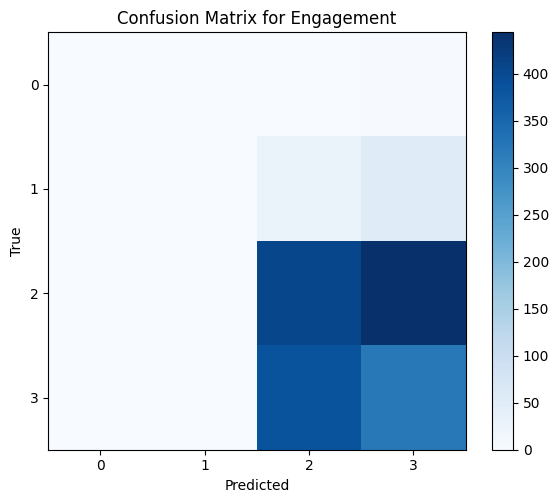

Classification report for Boredom:
              precision    recall  f1-score   support

           0      0.488     0.815     0.611       747
           1      0.475     0.198     0.280       519
           2      0.225     0.116     0.154       335
           3      0.000     0.000     0.000        37

    accuracy                          0.458      1638
   macro avg      0.297     0.283     0.261      1638
weighted avg      0.419     0.458     0.399      1638



c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

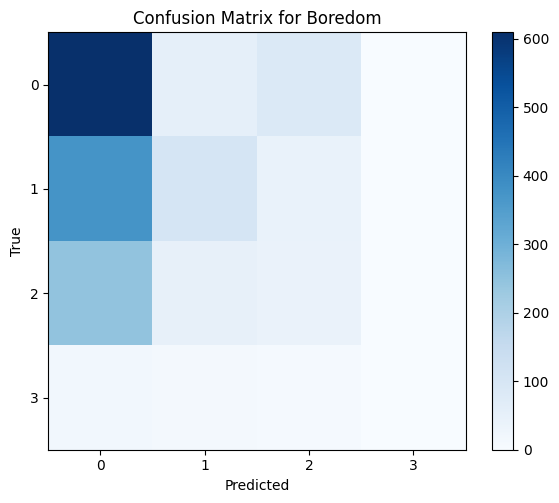

Classification report for Confusion:
              precision    recall  f1-score   support

           0      0.693     1.000     0.819      1135
           1      1.000     0.003     0.005       368
           2      0.000     0.000     0.000       116
           3      0.000     0.000     0.000        19

    accuracy                          0.694      1638
   macro avg      0.423     0.251     0.206      1638
weighted avg      0.705     0.694     0.569      1638



c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

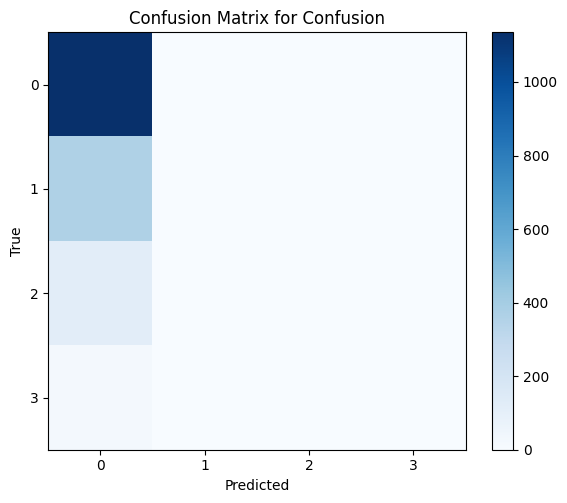

c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Classification report for Frustration:
              precision    recall  f1-score   support

           0      0.781     1.000     0.877      1279
           1      0.000     0.000     0.000       280
           2      0.000     0.000     0.000        56
           3      0.000     0.000     0.000        23

    accuracy                          0.781      1638
   macro avg      0.195     0.250     0.219      1638
weighted avg      0.610     0.781     0.685      1638



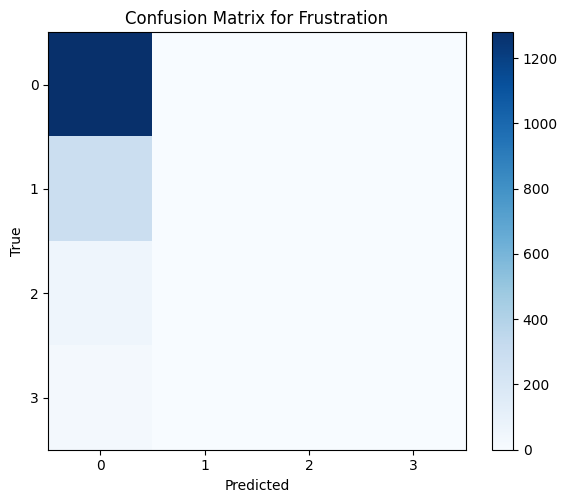


--- Evaluation Complete ---


In [8]:
# ------------------------------
# Main Execution Flow
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.set_start_method('spawn')
    import io  # required for LMDB conversion
    
    # CSV file paths
    train_csv = LABELS_DIR / "TrainLabels.csv"
    val_csv = LABELS_DIR / "ValidationLabels.csv"
    test_csv = LABELS_DIR / "TestLabels.csv"
    
    # Precompute frame paths and convert to LMDB for each CSV if not already done.
    for csv in [train_csv, val_csv, test_csv]:
        precompute_best_frames(csv, FRAMES_DIR, NUM_FRAMES)
        convert_pkl_to_lmdb(csv, NUM_FRAMES, transform=train_transform, lmdb_map_size=1 * 1024**3)
    
    # ------------------------------
    # Hyperparameter Tuning with Optuna (LMDB Dataset)
    # ------------------------------
    db_path = BASE_DIR / "tuning_eff.db"
    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
        storage=f"sqlite:///{db_path}",
        study_name="efficientnetb3_lstm_study",
        load_if_exists=True
    )
    TARGET_TRIALS = 10
    while True:
        successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
        remaining = TARGET_TRIALS - len(successful_trials)
        if remaining <= 0:
            break
        print(f"Running {remaining} additional trial(s) to reach {TARGET_TRIALS} successful trials...")
        study.optimize(objective, n_trials=remaining, catch=(Exception,))
    print(f"Optuna tuning complete. Total successful trials: {len(successful_trials)}")
    best_trial = min(successful_trials, key=lambda t: t.value)
    print("Best trial parameters:", best_trial.params)
    
    # ------------------------------
    # Final Training with Best Hyperparameters (LMDB Dataset)
    # ------------------------------
    final_checkpoint = MODEL_DIR / "final_model_eff_checkpoint.pth"
    if not final_checkpoint.exists():
        print("\n--- Starting Final Training ---")
        best_params = best_trial.params
        num_frames = best_params.get("num_frames", NUM_FRAMES)
        batch_size = best_params.get("batch_size", 8)
        # For safety on an 8GB GPU, cap batch size at 8.
        if batch_size > 8:
            print("Reducing final training batch size to 8 for safety.")
            batch_size = 8
        lr = best_params.get("lr", 1e-4)
        epochs = best_params.get("epochs", 5)
        hidden_size = best_params.get("hidden_size", 128)
        num_lstm_layers = best_params.get("num_lstm_layers", 1)
        
        train_set = VideoDatasetLMDB(train_csv, CACHE_DIR / f"lmdb_{train_csv.stem}_frame_{NUM_FRAMES}", num_frames=num_frames)
        val_set = VideoDatasetLMDB(val_csv, CACHE_DIR / f"lmdb_{val_csv.stem}_frame_{NUM_FRAMES}", num_frames=num_frames)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
        
        final_model = LSTMModel(feature_dim=1536, hidden_size=hidden_size, num_lstm_layers=num_lstm_layers).to(device)
        print(f"Final Training: batch_size={batch_size}, lr={lr:.0e}, hidden_size={hidden_size}")
        try:
            train_model(final_model, train_loader, val_loader, epochs, lr, final_checkpoint,
                        patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS)
        except RuntimeError as e:
            print("Final Training failed:", e)
            exit(1)
        if not final_checkpoint.exists():
            print("Final checkpoint not created; exiting.")
            exit(1)
    else:
        print("\n--- Skipping Final Training (Checkpoint Exists) ---")
        print(f"Using model from: {final_checkpoint}")
    
    # ------------------------------
    # Evaluation on Test Set (LMDB Dataset)
    # ------------------------------
    # For evaluation, use the best tuned batch size 
    best_params = study.best_trial.params
    eval_batch_size = best_params.get("batch_size", 8)
    test_set = VideoDatasetLMDB(test_csv, CACHE_DIR / f"lmdb_{test_csv.stem}_frame_{NUM_FRAMES}", num_frames=NUM_FRAMES)
    test_loader = DataLoader(test_set, batch_size=eval_batch_size, shuffle=False, num_workers=0)
    eval_model = LSTMModel(feature_dim=1536, hidden_size=best_params.get("hidden_size", 128),
                           num_lstm_layers=best_params.get("num_lstm_layers", 1)).to(device)
    if final_checkpoint.exists():
        state = torch.load(final_checkpoint, map_location=device)
        eval_model.load_state_dict(state['model_state_dict'])
    else:
        raise FileNotFoundError("Final checkpoint not found!")
    eval_model.to(device)
    try:
        evaluate_model(eval_model, test_loader)
    except RuntimeError as e:
        print("Evaluation failed due to CUDA memory issues:", e)
        exit(1)
    torch.cuda.empty_cache()
    gc.collect()
    print("\n--- Evaluation Complete ---")
